In [12]:
import pandas as pd
import datetime
import numpy as np
import geopandas as gpd
import pyogrio
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
years = [2017,2018,2019,2020,2021,2022]

In [3]:

dataframes = []
for y in years:
    filename = "data/wild_bird_data/ai-findings-" + str(y) + ".csv"
    df = pd.read_csv(filename,usecols = ["Week number","Location (county)","Total number of birds testing positive"])
    df["week"] = df["Week number"].map(lambda x: x.split()[1])
    df["year"] = df["Week number"].map(lambda x: x.split()[2][1:-1])
    df = df.drop(["Week number"], axis = 1)
    df = df[df["Total number of birds testing positive"]!=0]
    dataframes.append(df)
    
wild_bird_cases = pd.concat(dataframes).reset_index(drop = True)

In [4]:
wild_bird_cases["date"] = wild_bird_cases.apply(lambda x: datetime.datetime.strptime(str(x["year"])+ "-W" + str(x["week"]) + "-1", "%Y-W%W-%w"), axis = 1)

In [23]:
y = 2016
season = str(y)+ "/"+str(y+1)
end = datetime.date(y+1,9,30)
seasons = []
for i,x in wild_bird_cases.iterrows():
    while x["date"].date()>end:
        y+=1
        season = str(y)+ "/"+str(y+1)
        end = datetime.date(y+1,9,30)
    seasons.append(season)
wild_bird_cases["season"] = seasons
    
    

In [25]:
wild_bird_cases.to_csv("data/wild_bird_data/ai-findings-all.csv")

In [ ]:
notin = []
words_to_remove = ["District","Council", "Borough","City","Metropolitan","- new report from previously reported location","\xa0"]
words_to_replace = ["Norfolk","Suffolk", "Haringey","Fife","Warwickshire","Leicestershire","Lancashire","Oxfordshire","Cambridgeshire"]
new_locations = []
match = []
for x in wild_bird_cases["Location (county)"]:
    x_processed = x
    for w in words_to_remove:
        x_processed = x_processed.replace(w,"")
    for w in words_to_replace:
        if w in x_processed:
            x_processed = w
    x_processed = x_processed.strip("( )")
    if x_processed not in list(shapefile["CTYUA21NM"]):
        match.append(False)
        if x_processed not in notin:
            notin.append(x_processed)
    else:
        match.append(True)
    new_locations.append(x_processed)

In [ ]:
wild_bird_cases["location_2"] = new_locations
wild_bird_cases["Match"] = match

In [7]:
shapefile = gpd.read_file("data/geodata/Counties_and_Unitary_Authorities_(December_2021)_UK_BGC.shp")

In [5]:
wild_bird_cases_new_loc = pd.read_csv("data/wild_bird_data/ai-findings-all-location_changes.csv",usecols = [2,7,6],names=["cases","season","county"],header = None,skiprows = [0])

In [8]:
seasons = list(wild_bird_cases_new_loc["season"].unique())
locations = shapefile["CTYUA21NM"]
by_location_data = {}

for s in seasons:
    data = wild_bird_cases_new_loc[wild_bird_cases_new_loc["season"] == s]
    number_of_cases = {l:0 for l in locations}
    number_of_outbreaks = {l:0 for l in locations}
    for i,x in data.iterrows():
        county = x["county"]
        cases = x["cases"]
        number_of_cases[county] += cases
        number_of_outbreaks[county] += 1
    case_column = number_of_cases.values()
    outbreak_column = number_of_outbreaks.values()
    by_location_data[s] = pd.DataFrame({"county":locations,
                                     "cases": case_column,
                                     "outbreaks": outbreak_column})
    

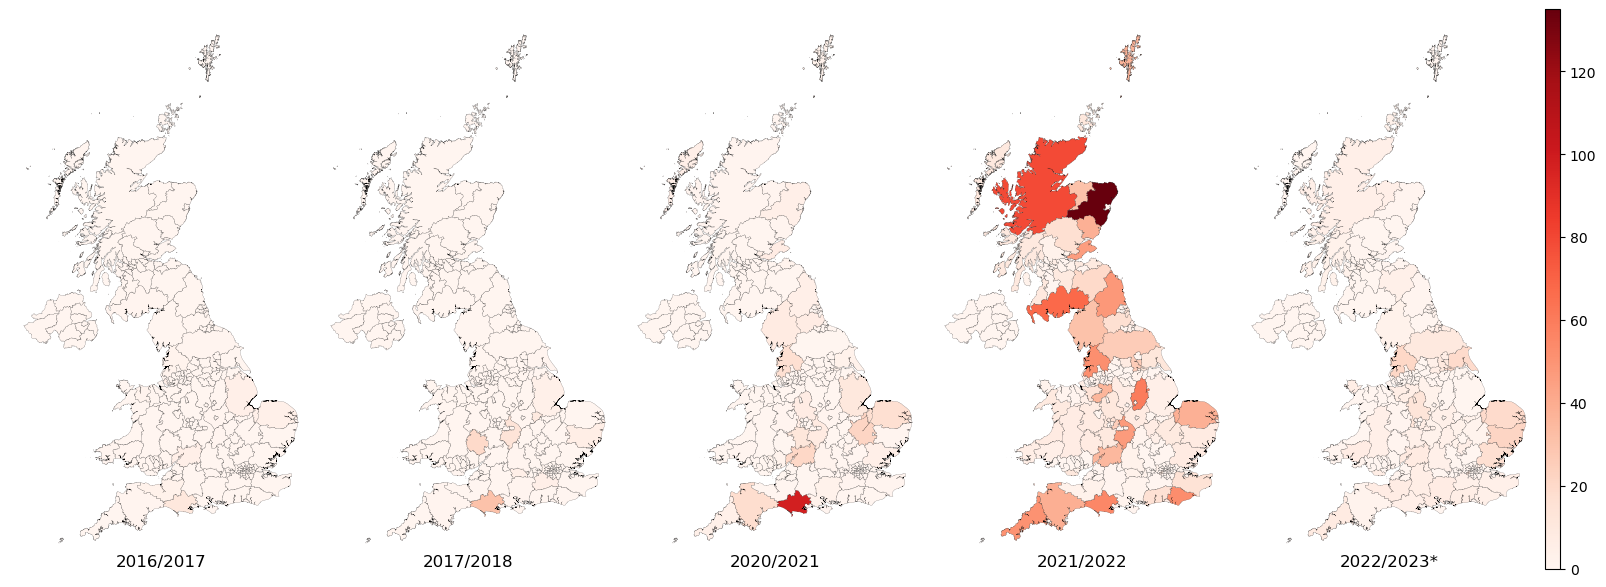

In [25]:
seasons = ["2016/2017","2017/2018","2020/2021","2021/2022","2022/2023*"]
max_outbreaks = max([by_location_data[s.strip("*")]["cases"].max() for s in seasons])

fig = plt.figure(figsize = (20,100))
grid = ImageGrid(fig, 111,
                nrows_ncols = (1,5),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

for i in range(5):
    shapefile["outbreaks"] = by_location_data[seasons[i].strip("*")]["cases"]
    imc = shapefile.plot(ax = grid[i],column = "outbreaks",cmap = "Reds",vmin=0, vmax=max_outbreaks,legend = False,edgecolor='black',linewidth = 0.1)
    
    grid[i].axis('off')
    grid[i].set_title(seasons[i],y=-0.01)

norm = Normalize(vmin=0, vmax=max_outbreaks)
n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
n_cmap.set_array([])
plt.colorbar(n_cmap, cax=grid.cbar_axes[0])

plt.savefig("uk_wildbird_cases.png",bbox_inches='tight')

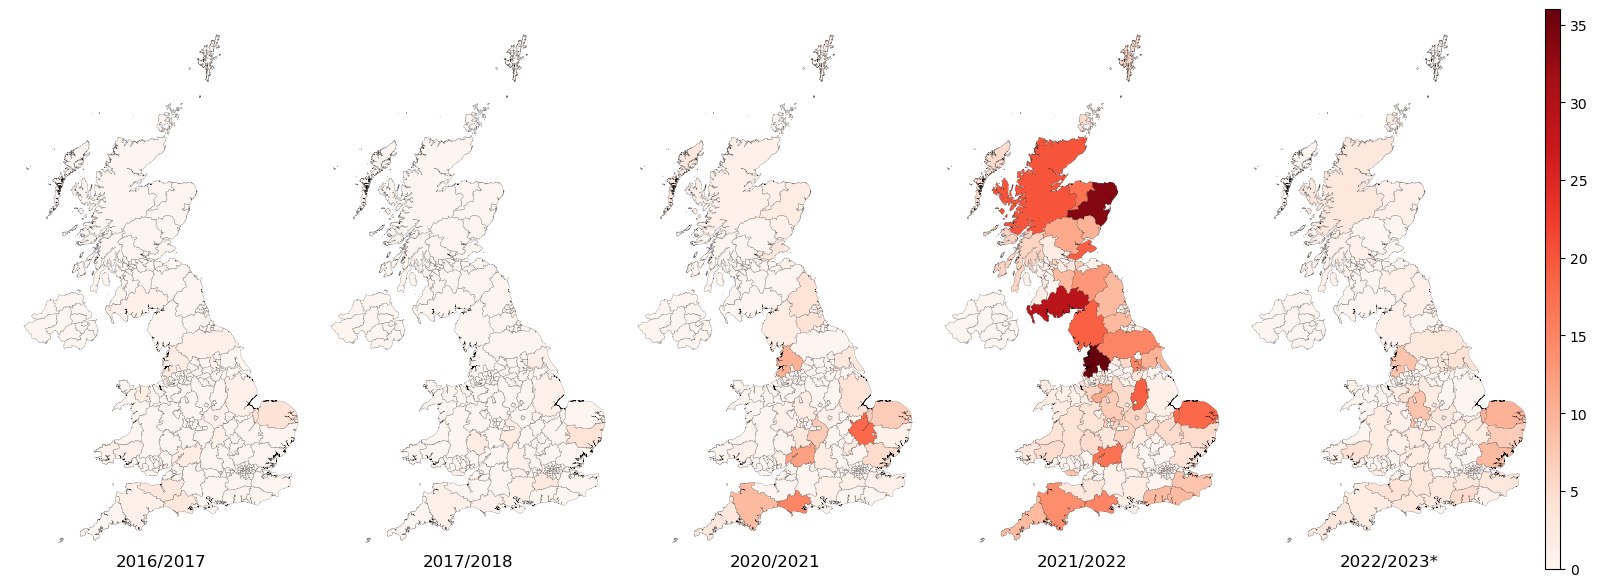

In [26]:
seasons = ["2016/2017","2017/2018","2020/2021","2021/2022","2022/2023*"]
max_outbreaks = max([by_location_data[s.strip("*")]["outbreaks"].max() for s in seasons])

fig = plt.figure(figsize = (20,100))
grid = ImageGrid(fig, 111,
                nrows_ncols = (1,5),
                axes_pad = 0.05,
                cbar_location = "right",
                cbar_mode="single",
                cbar_size="5%",
                cbar_pad=0.05
                )

for i in range(5):
    shapefile["outbreaks"] = by_location_data[seasons[i].strip("*")]["outbreaks"]
    shapefile.plot(ax = grid[i],column = "outbreaks",cmap = "Reds",vmin=0, vmax=max_outbreaks,legend = False,edgecolor='black',linewidth = 0.1)
    
    grid[i].axis('off')
    grid[i].set_title(seasons[i],y=-0.01)

norm = Normalize(vmin=0, vmax=max_outbreaks)
n_cmap = cm.ScalarMappable(norm=norm, cmap='Reds')
n_cmap.set_array([])
plt.colorbar(n_cmap, cax=grid.cbar_axes[0])

plt.savefig("uk_wildbird_outbreaks.png",bbox_inches='tight')